In [1]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [8]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import *
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import seaborn
import datetime
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [9]:
months = {1: "jan", 2: "feb", 3: "mar", 4: "apr", 5: "may", 6: "jun", 7: "jul", 8: "aug", 9: "sep", 10: "oct", 11: "nov", 12: "dec"}

startdate = datetime.datetime(year=2010, month=1, day=1, hour=0, minute=0, second=0)
curr = startdate
enddate = datetime.datetime(year=2018, month=1, day=1, hour=0, minute=0, second=0)

allhours = []

while curr < enddate:
    allhours.append(curr)
    curr += datetime.timedelta(hours=1)
    
trainhours = allhours[0:-8760] #all but last year, not a leap year
testhours = allhours[-8760:]
print(len(allhours))
print(len(trainhours))
print(len(testhours))

70128
61368
8760


In [10]:
#ERCOT data
subregions = ['COAST', 'EAST', 'FAR_WEST', 'NORTH', 'NORTH_C', 'SOUTHERN', 'SOUTH_C', 'WEST', 'ERCOT']
other_subregions = ['COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT']


lds = datetime.datetime(year=2016, month=2, day=29, hour=0, minute=0) #lines 1415 to 1439
lde = datetime.datetime(year=2016, month=2, day=29, hour=23, minute=0)

path = "/home/chase/projects/peakload/data/ercot/"
ercot2017 = pd.read_excel(path + "native_Load_2017.xlsx") #different subregions Index(['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH', 'SCENT', 'WEST', 'ERCOT'],dtype='object')
ercot2016 = pd.read_excel(path + "native_Load_2016.xlsx") #leap year
#ercot2016.drop(ercot2016.index[1415:1439], inplace=True) #this is the leap day

ercot2015 = pd.read_excel(path + "native_Load_2015.xls")
ercot2014 = pd.read_excel(path + "2014_ERCOT_Hourly_Load_Data.xls")
ercot2013 = pd.read_excel(path + "2013_ERCOT_Hourly_Load_Data.xls")
ercot2012 = pd.read_excel(path + "2012_ERCOT_Hourly_Load_Data.xls") #leap year
#ercot2012.drop(ercot2012.index[1415:1439], inplace=True) #this is the leap day

ercot2011 = pd.read_excel(path + "2011_ERCOT_Hourly_Load_Data.xls")
ercot2010 = pd.read_excel(path + "2010_ERCOT_Hourly_Load_Data.xls")

#ercotdata = list(ercot2010['ERCOT']) + list(ercot2011['ERCOT']) + list(ercot2012['ERCOT']) + list(ercot2013['ERCOT']) + list(ercot2014['ERCOT']) + list(ercot2015['ERCOT']) + list(ercot2016['ERCOT']) + list(ercot2017['ERCOT'])
yearly_data = {}
yearly_data['ERCOT'] = [list(ercot2010['ERCOT']), list(ercot2011['ERCOT']), list(ercot2012['ERCOT']), list(ercot2013['ERCOT']), list(ercot2014['ERCOT']), list(ercot2015['ERCOT']), list(ercot2016['ERCOT']), list(ercot2017['ERCOT'])]

for region in subregions:
    yearly_data[region] = [list(ercot2010[region]), list(ercot2011[region]), list(ercot2012[region]), list(ercot2013[region]), list(ercot2014[region]), list(ercot2015[region]), list(ercot2016[region])]

for region in other_subregions:
    r = subregions[other_subregions.index(region)]
    yearly_data[r].append(list(ercot2017[region]))

In [21]:
#use 2016
data2016 = np.asarray(yearly_data['ERCOT'][-2])
len(data2016)

8784

### ERCOT 0.2% forecast error at max (200 MW std)

In [25]:
#for a given peak reduction budget \Delta, reduce the top K peaks according to \Delta/K

budget_surf = np.zeros((50,20))
T = 21
deltas = np.arange(10,1000,20)
MC = 100

for j in range(deltas.shape[0]):
    print("Budget: ", deltas[j])
    delta = deltas[j]
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = data2016 + np.random.normal(0,200,size=(len(data2016,))) #standard deviation somewhere between 200 and 500
            top_i = list(reversed(np.argsort(X)))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.nanmax(X))
        expected_peaks.append(np.nanmean(peak_mc))
    budget_surf[j,:] = expected_peaks

Budget:  10
Budget:  30
Budget:  50
Budget:  70
Budget:  90
Budget:  110
Budget:  130
Budget:  150
Budget:  170
Budget:  190
Budget:  210
Budget:  230
Budget:  250
Budget:  270
Budget:  290
Budget:  310
Budget:  330
Budget:  350
Budget:  370
Budget:  390
Budget:  410
Budget:  430
Budget:  450
Budget:  470
Budget:  490
Budget:  510
Budget:  530
Budget:  550
Budget:  570
Budget:  590
Budget:  610
Budget:  630
Budget:  650
Budget:  670
Budget:  690
Budget:  710
Budget:  730
Budget:  750
Budget:  770
Budget:  790
Budget:  810
Budget:  830
Budget:  850
Budget:  870
Budget:  890
Budget:  910
Budget:  930
Budget:  950
Budget:  970
Budget:  990


<IPython.core.display.Javascript object>


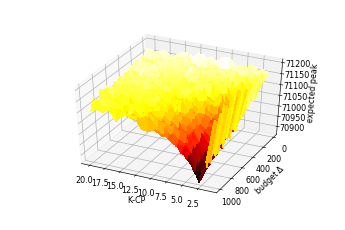

In [26]:
##need to plot surface instead of imshow
%matplotlib notebook

Y = np.arange(10,1000,20)
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### ERCOT 0.7% forecast error at max (500 MW std)

In [52]:
#for a given peak reduction budget \Delta, reduce the top K peaks according to \Delta/K

ercot_budget_surf = np.zeros((50,20))
T = 21
deltas = np.arange(10,1000,20)
MC = 1000

for j in range(deltas.shape[0]):
    print("Budget: ", deltas[j])
    delta = deltas[j]
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = data2016 + np.random.normal(0,500,size=(len(data2016,))) #standard deviation somewhere between 200 and 500
            top_i = list(reversed(np.argsort(X)))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.nanmax(X))
        expected_peaks.append(np.nanmean(peak_mc))
    ercot_budget_surf[j,:] = expected_peaks

Budget:  10
Budget:  30
Budget:  50
Budget:  70
Budget:  90
Budget:  110
Budget:  130
Budget:  150
Budget:  170
Budget:  190
Budget:  210
Budget:  230
Budget:  250
Budget:  270
Budget:  290
Budget:  310
Budget:  330
Budget:  350
Budget:  370
Budget:  390
Budget:  410
Budget:  430
Budget:  450
Budget:  470
Budget:  490
Budget:  510
Budget:  530
Budget:  550
Budget:  570
Budget:  590
Budget:  610
Budget:  630
Budget:  650
Budget:  670
Budget:  690
Budget:  710
Budget:  730
Budget:  750
Budget:  770
Budget:  790
Budget:  810
Budget:  830
Budget:  850
Budget:  870
Budget:  890
Budget:  910
Budget:  930
Budget:  950
Budget:  970
Budget:  990


<IPython.core.display.Javascript object>


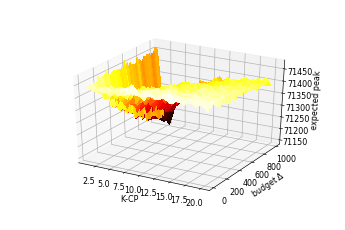

In [53]:
Y = np.arange(10,1000,20)
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, ercot_f_budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

### Monthly peaks 1 - 12

In [79]:
#divide the data up into 12 groups
#take peak from each of 1-12 groups

data2016arr = np.zeros((12,732))
for i in range(12):
    data2016arr[i,:] = data2016[i*732:(i+1)*732]


In [83]:
monthly_peaks = np.max(data2016arr, axis=1)
top_i = list(reversed(np.argsort(monthly_peaks)))
peak_times = np.argmax(data2016arr, axis=1)

In [86]:
top_i

[10, 7, 6, 8, 5, 9, 11, 4, 3, 0, 1, 2]

In [85]:
X = copy.copy(data2016arr)

In [ ]:
T = 12
MC = 1000
deltas = np.arange(10,500,20)
monthly_budget_surf = np.zeros((25,T))

for j in range(deltas.shape[0]):
    delta = deltas[j]
    print("budget: ", np.around(delta, decimals=2))
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        X = copy.copy(data2016arr) + np.random.normal(0,500,size=(data2016arr.shape))

### Deterministic forecast

In [44]:
### Sin curve, assume deterministic function is true forecast, reduce top K-peaks as function of budget

T = 41
forecast = 2*np.sin(0.5*np.arange(0,T,1)) + 0.01*np.arange(0,T,1) #ensure it has distinct marginally different peaks
deltas = np.arange(0.2,10.2,0.2)
MC = 1000

sin_budget_surf = np.zeros((50,40))

for j in range(deltas.shape[0]):
    delta = deltas[j]
    print("budget: ", np.around(delta,decimals=2))
    expected_peaks = []
    top_i = list(reversed(np.argsort(forecast)))
    X_f = copy.copy(forecast)
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = X_f + np.random.normal(0,1,size=(T,))
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.max(X))
        expected_peaks.append(np.mean(peak_mc))
    sin_budget_surf[j,:] = expected_peaks

### apply noise, compute expected peak

budget:  0.2
budget:  0.4
budget:  0.6
budget:  0.8
budget:  1.0
budget:  1.2
budget:  1.4
budget:  1.6
budget:  1.8
budget:  2.0
budget:  2.2
budget:  2.4
budget:  2.6
budget:  2.8
budget:  3.0
budget:  3.2
budget:  3.4
budget:  3.6
budget:  3.8
budget:  4.0
budget:  4.2
budget:  4.4
budget:  4.6
budget:  4.8
budget:  5.0
budget:  5.2
budget:  5.4
budget:  5.6
budget:  5.8
budget:  6.0
budget:  6.2
budget:  6.4
budget:  6.6
budget:  6.8
budget:  7.0
budget:  7.2
budget:  7.4
budget:  7.6
budget:  7.8
budget:  8.0
budget:  8.2
budget:  8.4
budget:  8.6
budget:  8.8
budget:  9.0
budget:  9.2
budget:  9.4
budget:  9.6
budget:  9.8
budget:  10.0


In [45]:
plt.plot(sin_budget_surf[j,:])
plt.show()

<IPython.core.display.Javascript object>


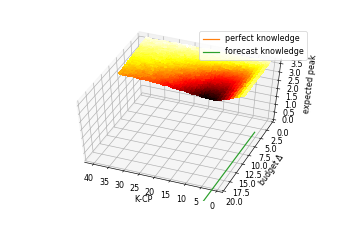

In [46]:
Y = np.arange(0.2,10.2,0.2)
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, sin_budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [54]:
### Assume ERCOT load is true forecast, reduce top K-peaks as function of budget

### apply noise, compute expected peak

#for a given peak reduction budget \Delta, reduce the top K peaks according to \Delta/K

ercot_f_budget_surf = np.zeros((50,20))
T = 21
deltas = np.arange(10,1000,20)
MC = 1000

top_i = list(reversed(np.argsort(data2016)))
X_f = copy.copy(data2016)

for j in range(deltas.shape[0]):
    delta = deltas[j]
    print("Budget: ", np.around(delta,decimals=2))
    expected_peaks = []
    for k in range(1,T):
        peak_mc = []
        for mc in range(MC):
            X = X_f + np.random.normal(0,500,size=(len(data2016,))) #standard deviation somewhere between 200 and 500
            for cp in range(k):
                X[top_i[cp]] = X[top_i[cp]] - float(delta/float(k))
            peak_mc.append(np.nanmax(X))
        expected_peaks.append(np.nanmean(peak_mc))
    ercot_f_budget_surf[j,:] = expected_peaks

Budget:  10
Budget:  30
Budget:  50
Budget:  70
Budget:  90
Budget:  110
Budget:  130
Budget:  150
Budget:  170
Budget:  190
Budget:  210
Budget:  230
Budget:  250
Budget:  270
Budget:  290
Budget:  310
Budget:  330
Budget:  350
Budget:  370
Budget:  390
Budget:  410
Budget:  430
Budget:  450
Budget:  470
Budget:  490
Budget:  510
Budget:  530
Budget:  550
Budget:  570
Budget:  590
Budget:  610
Budget:  630
Budget:  650
Budget:  670
Budget:  690
Budget:  710
Budget:  730
Budget:  750
Budget:  770
Budget:  790
Budget:  810
Budget:  830
Budget:  850
Budget:  870
Budget:  890
Budget:  910
Budget:  930
Budget:  950
Budget:  970
Budget:  990


<IPython.core.display.Javascript object>


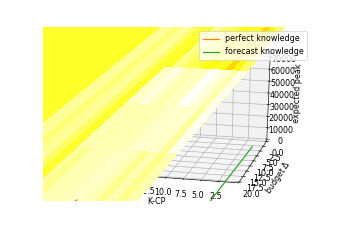

In [55]:
Y = np.arange(10,1000,20)
X = np.arange(1,T,1)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, ercot_f_budget_surf, rstride=1, cstride=1, cmap='hot', linewidth=0, antialiased=False)
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel('K-CP')
ax.set_ylabel('budget $\Delta$')
ax.set_zlabel('expected peak')

#fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [72]:
#plot the min peak # of CP for ercot_budget_surf and ercot_f_budget_surf
forecast_min_peak = []
perfect_min_peak = []

for j in range(ercot_budget_surf.shape[0]):
    forecast_min_peak.append(np.argmin(ercot_f_budget_surf[j,:]))
    perfect_min_peak.append(np.argmin(ercot_budget_surf[j,:]))


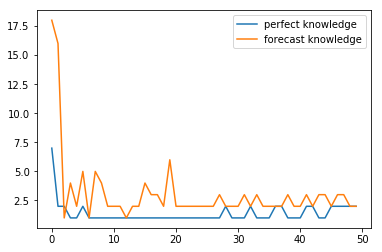

In [73]:
%matplotlib inline
plt.plot(np.array(perfect_min_peak), label="perfect knowledge")
plt.plot(np.array(forecast_min_peak), label="forecast knowledge")
plt.legend()
#plt.ylim(0,20)
plt.show()

In [ ]:
### Assume ERCOT load is true forecast, reduce top K-monthly peaks as function of budget

### apply noise, compute expected peak